In [48]:
## import dependencies
import numpy as np
import pandas as pd

## deep learning dependencies 
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import *
from keras.optimizers import *

## QuestDB dependencies
import io
import requests
import urllib.parse as par

## timestamp dependencies 
from datetime import datetime

## visualisation dependencies
import matplotlib.pyplot as plt
%matplotlib inline

In [49]:
# read dataset using pandas library
df = pd.read_excel('Excelrates.xlsx')
## check first few rows of the dataset
df.head()

,Date,USD,INR
0,2022-02-06,1,74.7073
1,2022-02-05,1,74.7073
2,2022-02-04,1,74.7073
3,2022-02-03,1,74.8875
4,2022-02-02,1,74.7267


In [ ]:
## create table query 
q = 'create table excel_rates'\
    '(Date timestamp,'\
    'USD int,'\
    'INR double)'
## connect to QuestDB URL and execute the query
r = requests.get("http://localhost:9000/exec?query=" + q)

## print the status code once executed the table creation query
print(r.status_code)

In [12]:
## variables for tracking successful execution of queries 
success = 0
fail = 0

## iterate over each row and store it in the QuestDB table 
for i, row in df.iterrows():
    date = row['Date']
    ## convert date to datetime format to store in DB
    date = "'"+date.strftime('%Y-%m-%dT%H:%M:%S.%fZ')+"'"
    usd = row['USD']
    inr = row['INR']
    query = "insert into excel_rates values(" + date + "," + str(usd) + ","  + str(inr) +")"
    r = requests.get("http://localhost:9000/exec?query=" + query)
    if r.status_code == 200:
        success += 1
    else:
        fail += 1
        
## check if the execution is successful or not
if fail > 0:
    print("Rows Failed: " + str(fail))
if success > 0:
    print("Rows inserted: " + str(success))

Rows inserted: 8435


In [50]:
## select data from QuestDB
r = requests.get("http://localhost:9000/exp?query=select * from excel_rates")
rawData = r.text

## convert Bytes to CSV format and read using pandas library
df = pd.read_csv(io.StringIO(rawData), parse_dates=['Date'])
df.columns 

Index(['Date', 'USD', 'INR'], dtype='object')

In [51]:
## drop USD column from the dataframe
df = df.drop('USD', axis=1)
## convert Date column to datetime format
df['Date'] = pd.to_datetime(df["Date"])
## set Date as index 
indexed_df = df.set_index(["Date"], drop=True)
indexed_df.head()

,INR
Date,
1999-01-04 00:00:00+00:00,0.0000
2022-02-06 00:00:00+00:00,74.7073
2022-02-05 00:00:00+00:00,74.7073
2022-02-04 00:00:00+00:00,74.7073
2022-02-03 00:00:00+00:00,74.8875


<AxesSubplot:xlabel='Date'>

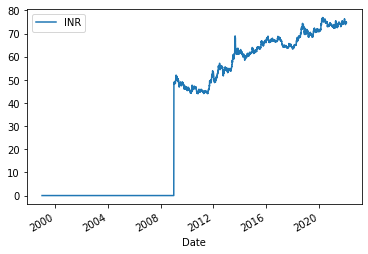

In [52]:
indexed_df.plot()

In [53]:
indexed_df = indexed_df[indexed_df.INR != 0.0]
indexed_df = indexed_df.iloc[::-1]
indexed_df.head()

,INR
Date,
2009-01-02 00:00:00+00:00,48.4098
2009-01-03 00:00:00+00:00,48.4098
2009-01-04 00:00:00+00:00,48.4098
2009-01-05 00:00:00+00:00,48.5149
2009-01-06 00:00:00+00:00,48.6251


In [54]:
## shift INR values by 1 
shifted_df= indexed_df.shift()
## merge INR and Shifter INR values 
concat_df = [indexed_df, shifted_df]
data = pd.concat(concat_df,axis=1)
## Replace NaNs with 0
data.fillna(0, inplace=True)
data.head()

,INR,INR
Date,,
2009-01-02 00:00:00+00:00,48.4098,0.0000
2009-01-03 00:00:00+00:00,48.4098,48.4098
2009-01-04 00:00:00+00:00,48.4098,48.4098
2009-01-05 00:00:00+00:00,48.5149,48.4098
2009-01-06 00:00:00+00:00,48.6251,48.5149


In [55]:
## convert data to numpy array 
data = np.array(data)
## you can take last 500 data points as test set
train , test = data[0:-500], data[-500:]

In [56]:
# Scale
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

# train data
y_train = train_scaled[:,-1]
X_train = train_scaled[:,0:-1]
X_train = X_train.reshape(len(X_train),1,1)

#test data
y_test = test_scaled[:,-1]
X_test = test_scaled[:,0:-1]

In [33]:
## GRU Model
model = Sequential()
## GRU layer 
model.add(GRU(75, input_shape=(1,1)))
## output layer 
model.add(Dense(1))
optimizer = Adam(lr=1e-3)
model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['accuracy'])
model.fit(X_train, y_train, epochs=100, batch_size=20, shuffle=False)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/100
4284/4284 [==============================] - 2s 361us/step - loss: 0.0519 - acc: 4.6685e-04
Epoch 2/100
4284/4284 [==============================] - 1s 207us/step - loss: 1.0326e-04 - acc: 2.3343e-04
Epoch 3/100
4284/4284 [==============================] - 1s 191us/step - loss: 1.0221e-04 - acc: 2.3343e-04
Epoch 4/100
4284/4284 [==============================] - 1s 180us/step - loss: 1.0224e-04 - acc: 2.3343e-04
Epoch 5/100
4284/4284 [==============================] - 1s 175us/step - loss: 1.0233e-04 - acc: 2.3343e-04
Epoch 6/100
4284/4284 [==============================] - 1s 173us/step - loss: 1.0247e-04 - acc: 2.3343e-04
Epoch 7/100
4284/4284 [==============================] - 1s 170us/step - loss: 1.0268e-04 - acc: 2.3343e-04
Epoch 8/100
4284/4284 [==============================] - 1s 173us/step - loss: 1.0291e-04 - acc: 2.3343e-04
Epoch 9/100
4284/428

Epoch 71/100
4284/4284 [==============================] - 1s 167us/step - loss: 1.1667e-04 - acc: 2.3343e-04
Epoch 72/100
4284/4284 [==============================] - 1s 161us/step - loss: 1.1660e-04 - acc: 2.3343e-04
Epoch 73/100
4284/4284 [==============================] - 1s 164us/step - loss: 1.1656e-04 - acc: 2.3343e-04
Epoch 74/100
4284/4284 [==============================] - 1s 162us/step - loss: 1.1651e-04 - acc: 2.3343e-04
Epoch 75/100
4284/4284 [==============================] - 1s 160us/step - loss: 1.1645e-04 - acc: 2.3343e-04
Epoch 76/100
4284/4284 [==============================] - 1s 161us/step - loss: 1.1639e-04 - acc: 2.3343e-04
Epoch 77/100
4284/4284 [==============================] - 1s 164us/step - loss: 1.1634e-04 - acc: 2.3343e-04
Epoch 78/100
4284/4284 [==============================] - 1s 170us/step - loss: 1.1629e-04 - acc: 2.3343e-04
Epoch 79/100
4284/4284 [==============================] - 1s 164us/step - loss: 1.1625e-04 - acc: 2.3343e-04
Epoch 80/100
4284/4

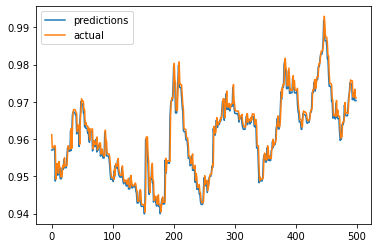

In [57]:
## make predictions for test set 
X_test = X_test.reshape(500,1,1)
y_pred = model.predict(X_test)

## visualise results
plt.plot(y_pred, label = 'predictions')
plt.plot(y_test, label = 'actual')
plt.legend()

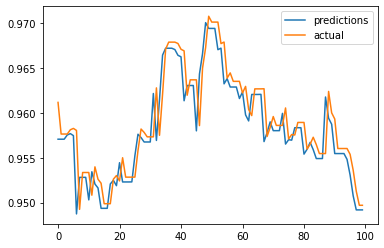

In [58]:
## visualize results
plt.plot(y_pred[:100], label = 'predictions')
plt.plot(y_test[:100], label = 'actual')
plt.legend()